# Forecasting

In [58]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Utilities

In [59]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data
    Args:
        time (array of int) - contains the time steps
        series (array of int) - contains the measurements for each time step
        format - line style when plotting the graph
        start - first time step to plot
        end - last time step to plot
    """
    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:
        for series_num in series:
            # Plot the time series data
            plt.plot(time[start:end], series_num[start:end], format)
    else:
        # Plot the time series data
        plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

def trend(time, slope=0):
    """
    Generates synthetic data that follows a straight line given a slope value.
    Args:
        time (array of int) - contains the time steps
        slope (float) - determines the direction and steepness of the line

    Returns:
        series (array of float) - measurements that follow a straight line
    """
    # Compute the linear series given the slope
    series = slope * time

    return series

def seasonal_pattern(season_time):
    """
    Just an arbitrary pattern, you can change it if you wish
    Args:
        season_time (array of float) - contains the measurements per time step
    Returns:
        data_pattern (array of float) -  contains revised measurement values according
                                  to the defined pattern
    """
    # Generate the values using an arbitrary pattern
    data_pattern = np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

    return data_pattern

def seasonality(time, period, amplitude=1, phase=0):
    """
    Repeats the same pattern at each period
    Args:
        time (array of int) - contains the time steps
        period (int) - number of time steps before the pattern repeats
        amplitude (int) - peak measured value in a period
        phase (int) - number of time steps to shift the measured values
    Returns:
        data_pattern (array of float) - seasonal data scaled by the defined amplitude
    """
    # Define the measured values per period
    season_time = ((time + phase) % period) / period

    # Generates the seasonal data scaled by the defined amplitude
    data_pattern = amplitude * seasonal_pattern(season_time)

    return data_pattern

def noise(time, noise_level=1, seed=None):
    """Generates a normally distributed noisy signal
    Args:
        time (array of int) - contains the time steps
        noise_level (float) - scaling factor for the generated signal
        seed (int) - number generator seed for repeatability
    Returns:
        noise (array of float) - the noisy signal
    """
    # Initialize the random number generator
    rnd = np.random.RandomState(seed)

    # Generate a random number for each time step and scale by the noise level
    noise = rnd.randn(len(time)) * noise_level

    return noise

## Generate Data

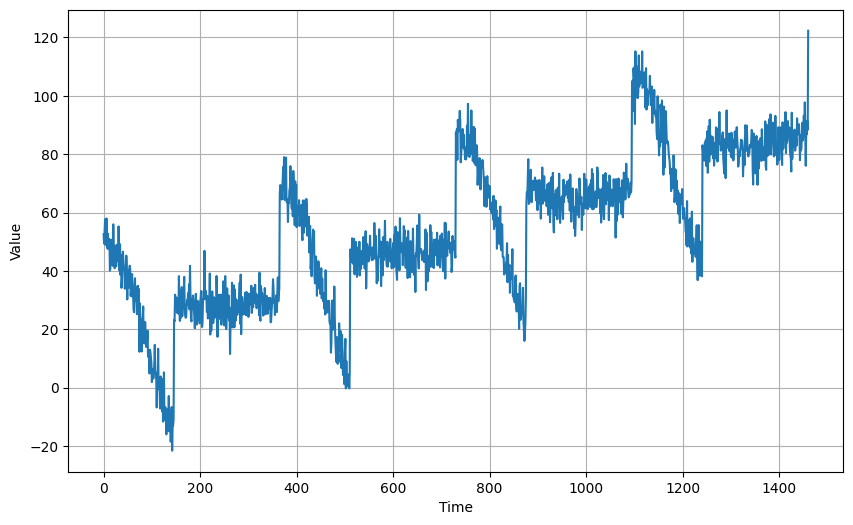

In [60]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [61]:
# Define the split time
SPLIT_TIME = 1000

# Get the train set
time_train = time[:SPLIT_TIME]
x_train = series[:SPLIT_TIME]

# Get the validation set
time_valid = time[SPLIT_TIME:]
x_valid = series[SPLIT_TIME:]

## Prepare Features and Labels

In [62]:
# Parameters
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [87]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, example=False):
    """Generates dataset windows
    Args:
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the feature
        batch_size (int) - the batch size
        shuffle_buffer(int) - buffer size to use for the shuffle method
    Returns:
        dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size, + 1 indicates that we're taking the next point as the label
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch, we need tensors instead of the Dataset structure for training.
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    if example:
        print('Example of the first feature and label:\n')
        for x, y in dataset.take(1):
            print("x = ", x.numpy(), type(x))
            print("y = ", y.numpy(), type(y), '\n')

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer) # return a batched dataset with that number of windows

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    if example:
        print('Example of the first batch:\n')
        for x, y in dataset.take(1):
            print("x = ", x.numpy())
            print("y = ", y.numpy())

    return dataset

In [88]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE, example=True)

Example of the first feature and label:

x =  [52.48357  49.35275  53.314735 57.711823 48.934444 48.931244 57.982895
 53.897125 47.67393  52.68371  47.591717 47.506374 50.959415 40.086178
 40.919415 46.612473 44.228207 50.720642 44.454983 41.76799 ] <class 'tensorflow.python.framework.ops.EagerTensor'>
y =  55.980938 <class 'tensorflow.python.framework.ops.EagerTensor'> 

Example of the first batch:

x =  [[ 29.591013    25.8548      34.145004    28.563086    25.200027
   27.749893    31.45096     26.59733     25.334665    30.694183
   30.730724    27.001482    27.211473    30.757544    22.38766
   22.621704    26.097902    28.654142    31.307323    37.161125  ]
 [ 22.487074    18.91756     13.98788     18.565226    15.84603
   19.565367    10.573323    11.806878    10.846607     4.8520856
   13.013545    12.202472    10.28818      8.456475     1.9209299
    6.2647085    6.02649      3.1029897    5.6846423    7.8905945 ]
 [ 25.366972    38.226013    31.225473    22.859697    32.05963
 

In [65]:
# Print shapes of feature and label
for window in dataset.take(1):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)


## Model

The model expect a 3-dimensional tensor input with the shape [batch, timesteps, feature]. With that, you need to reshape your window from (32, 20) to (32, 20, 1).

In [66]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE]), # adds a dimension at the last axis of the input
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0) # scaling up the output to around the same figures as your labels
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

## Tune the Learning Rate

In [67]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 9s 54ms/step - loss: 15.9173 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 15ms/step - loss: 15.6738 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 15ms/step - loss: 15.3779 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 15ms/step - loss: 15.0516 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 14.6951 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 15ms/step - loss: 14.2980 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 15ms/step - loss: 13.8725 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 15ms/step - loss: 13.4211 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 16ms/step - loss: 12.9506 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 12.4876 - lr: 2.8184e-08
Epoch 11/

(1e-08, 0.001, 0.0, 50.0)

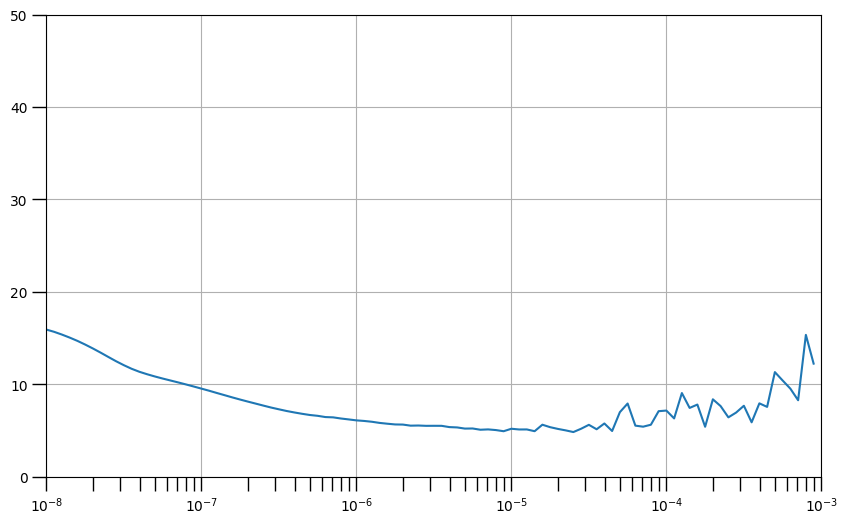

In [71]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 50])

## Train the Model

In [89]:
# Generate data windows of the validation set
val_set = windowed_dataset(x_valid, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER_SIZE)

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        '''
        Halts the training when a certain metric is met
        Args:
            epoch (integer) - index of epoch (required but unused in the function definition below)
            logs (dict) - metric results from the training epoch
        '''
        # Check the validation set MAE
        if logs.get('val_mae') < 6:
            # Stop if threshold is met
            print("\nRequired val MAE is met so cancelling training!")
            self.model.stop_training = True
# Instantiate the class
callbacks = MyCallback()

In [80]:
# Set the learning rate
LEARNING_RATE = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])

# Train the model
history = model.fit(dataset, epochs=100, validation_data=val_set, callbacks=[callbacks])

Epoch 1/100
31/31 [==============================] - 3s 32ms/step - loss: 18.6879 - mae: 19.1812 - val_loss: 17.1336 - val_mae: 17.6277
Epoch 2/100
31/31 [==============================] - 0s 9ms/step - loss: 10.2657 - mae: 10.7554 - val_loss: 14.1598 - val_mae: 14.6536
Epoch 3/100
31/31 [==============================] - 0s 9ms/step - loss: 9.3144 - mae: 9.8022 - val_loss: 13.6667 - val_mae: 14.1580
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 9.0105 - mae: 9.4974 - val_loss: 10.7492 - val_mae: 11.2385
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 8.5198 - mae: 9.0081 - val_loss: 13.3736 - val_mae: 13.8653
Epoch 6/100
31/31 [==============================] - 0s 9ms/step - loss: 6.9323 - mae: 7.4154 - val_loss: 6.9051 - val_mae: 7.3895
Epoch 7/100
31/31 [==============================] - 0s 9ms/step - loss: 7.6423 - mae: 8.1300 - val_loss: 15.5334 - val_mae: 16.0259
Epoch 8/100
31/31 [==============================] - 0s 9ms/step -

## Accuracy and Loss

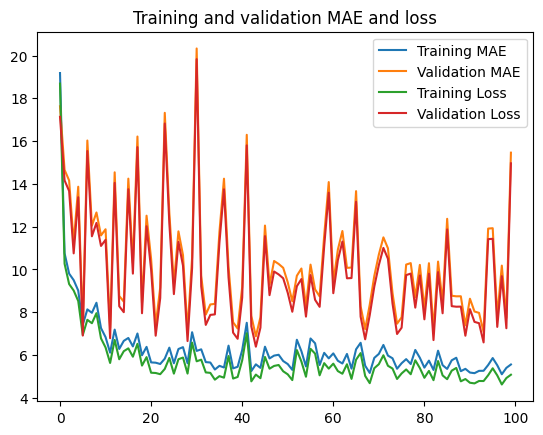

In [91]:
def plot_acc_val(history):
    mae = history.history['mae']
    val_mae = history.history['val_mae']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(mae)) # Get number of epochs

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, mae, label='Training MAE')
    plt.plot(epochs, val_mae, label='Validation MAE')

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and validation MAE and Loss')
    plt.legend()

plot_acc_val(history)

## Model Prediction

In [76]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows
    Args:
        model (TF Keras Model) - model that accepts data windows
        series (array of float) - contains the values of the time series
        window_size (int) - the number of time steps to include in the window
        batch_size (int) - the batch size
    Returns:
        forecast (numpy array) - array containing predictions
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

15/15 [==============================] - 0s 5ms/step


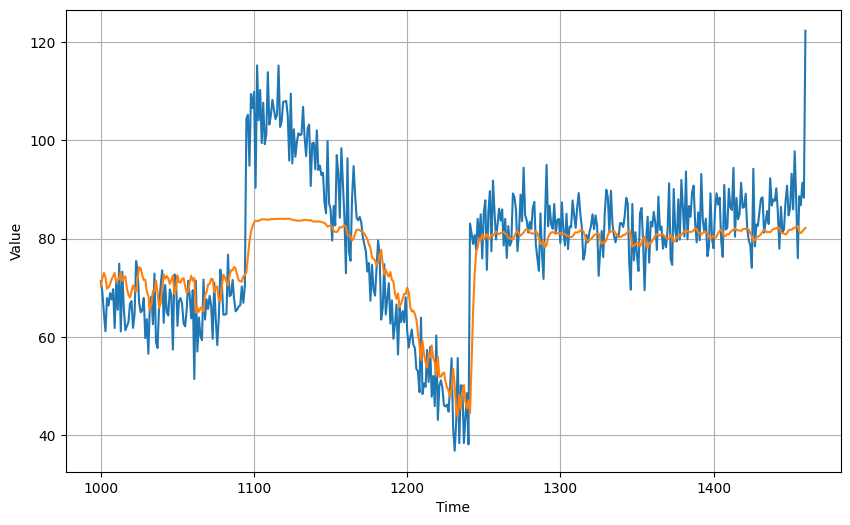

In [77]:
# Reduce the original series
forecast_series = series[SPLIT_TIME - WINDOW_SIZE: -1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, WINDOW_SIZE, BATCH_SIZE)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [78]:
# Compute the MSE and MAE
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

90.65306
6.9962754
